# Prevendo as Tarifas de Corridas de Taxi com Deep Feedfoward Networks

Este trabalho tem como sua base o terceiro capítulo do livro [Neural Network Projects with Python](https://www.amazon.com.br/Neural-Network-Projects-Python-James/dp/1789138906). Neste capítulo o autor usa o James Loy mostra como usar a biblioteca [Keras](https://keras.io/) para criar Deep Feed Neural Network com intuito de prever as tarifas cobradas de corridas de taxi do famoso dataset [New York City Taxi Fare Prediction](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data).

Neste notebook você podera encontrar algumas diferenças do encontrado no livro ou mesmo no [repósitorio](https://github.com/PacktPublishing/Neural-Network-Projects-with-Python/tree/master/Chapter03) do livro do autor, como por exemplo a parte de análise exploratória um pouco mais extensa, feature engineering e otimização da rede neural criada para resolver o problema de classificação do dataset.

In [1]:
# Manipulação de Dados
import numpy as np
import pandas as pd

# Visualização de Dados
import matplotlib.pyplot as plt
import seaborn as sns

# Data Mining
import pingouin as pg
from scipy import stats

# Pré-processamento e Deep Learning
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense

# Métricas
from sklearn.metrics import confusion_matrix, roc_curve

# Configurando o estilo de gráfico utilizado
%matplotlib inline
plt.rcParams["figure.figsize"] = 20, 10
plt.style.use('fivethirtyeight')
sns.set_palette('gist_ncar')

# Ignorando os avisos
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Carregando o dataset
df = pd.read_csv('Data/NYC_taxi.csv', parse_dates=['pickup_datetime'], nrows=2000000)

In [3]:
# Checando as primeiras linhas do dataset
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


In [4]:
# Cheacando as informações sobre as colunas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 8 columns):
 #   Column             Dtype              
---  ------             -----              
 0   key                object             
 1   fare_amount        float64            
 2   pickup_datetime    datetime64[ns, UTC]
 3   pickup_longitude   float64            
 4   pickup_latitude    float64            
 5   dropoff_longitude  float64            
 6   dropoff_latitude   float64            
 7   passenger_count    int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 122.1+ MB


In [5]:
# Excluindo a variável "key"
df.drop('key', axis=1, inplace=True)

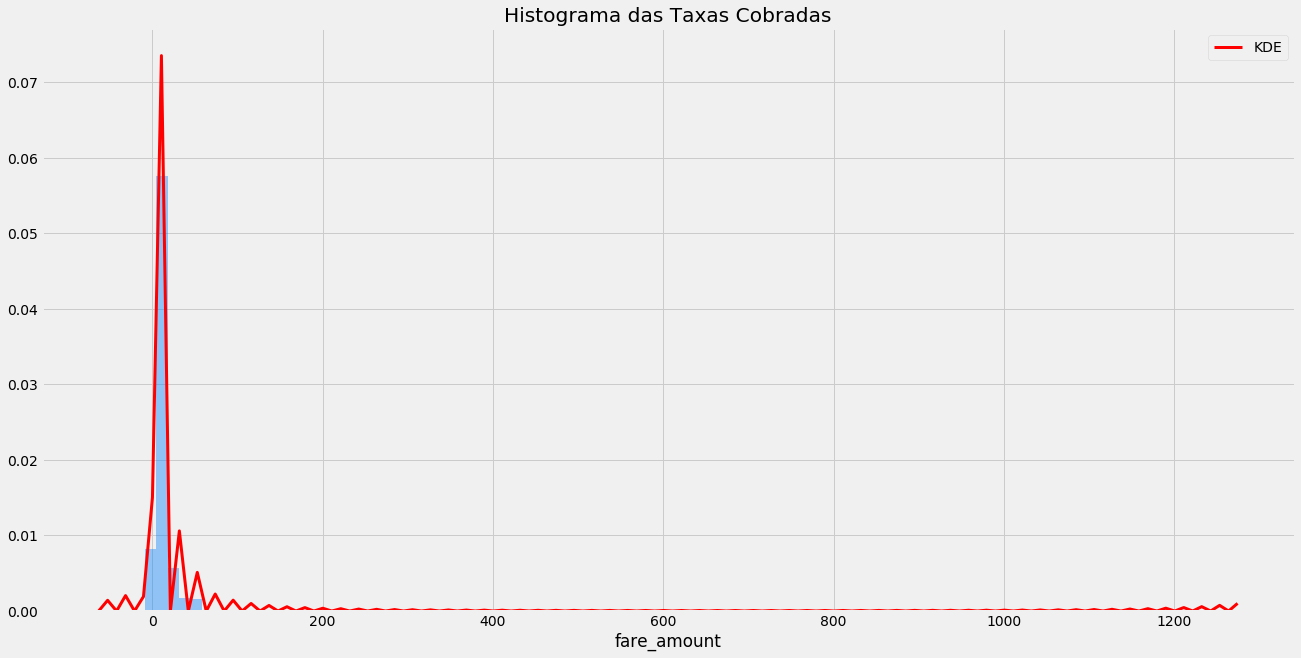

In [6]:
# Histograma e density plot para a variável 'fare_amount'
sns.distplot(df['fare_amount'],
             bins=100,
             hist=True, 
             kde_kws={'color':'r', 'lw':3, 'label':'KDE'})

# Plota o histograma
plt.title('Histograma das Taxas Cobradas')
plt.show()

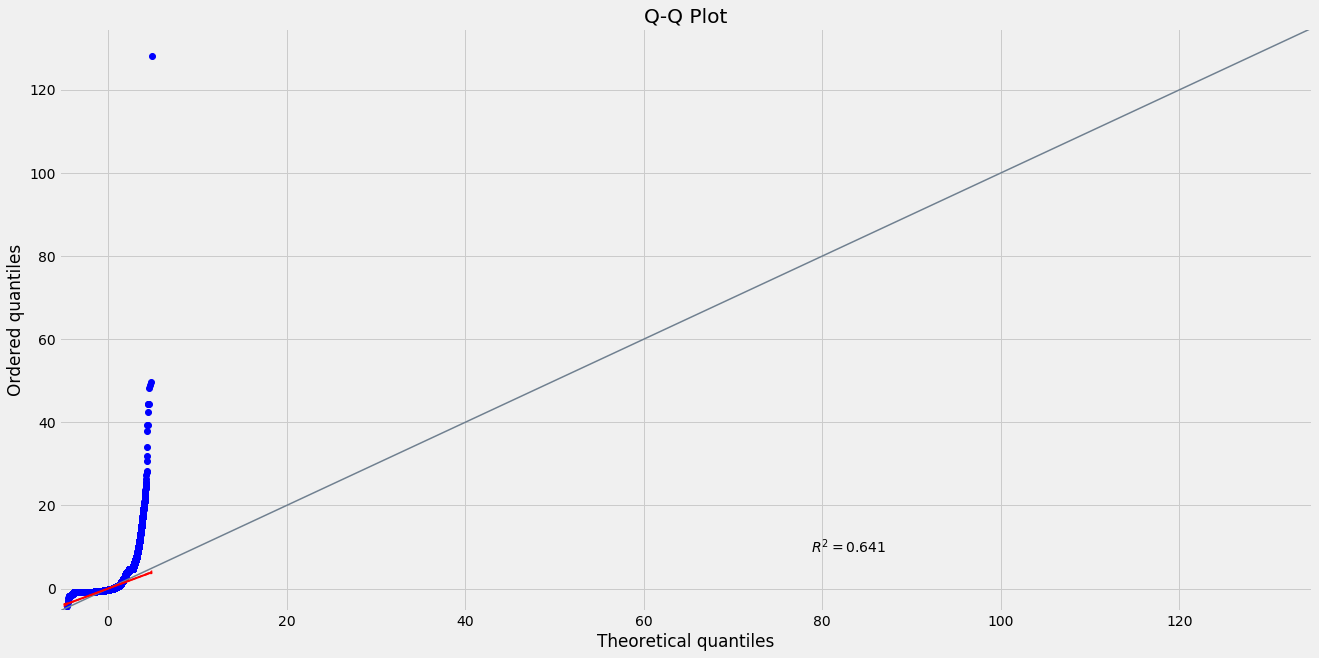

In [7]:
# Cria o gráfico
pg.qqplot(df['fare_amount'], 
          dist='norm', 
          figsize=(20, 10))

# Mostra o gráfico
plt.show()

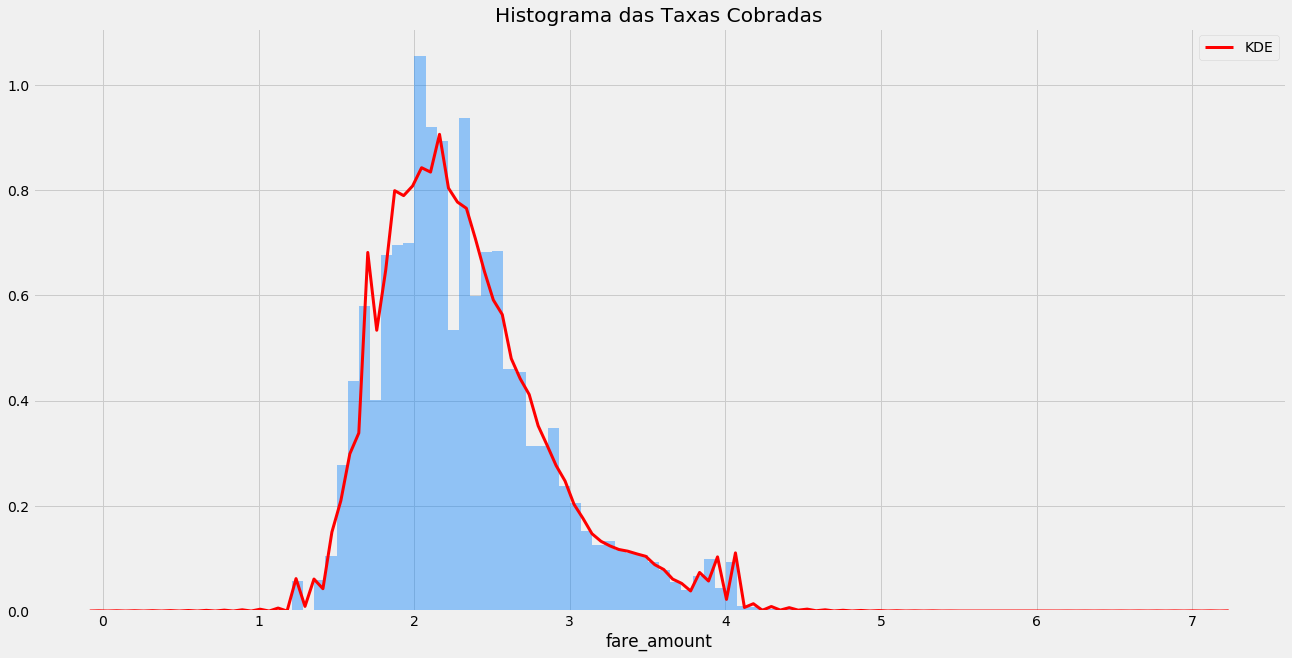

In [8]:
# Histograma e density plot para a variável 'fare_amount'
sns.distplot(np.log1p(df['fare_amount']),
             bins=100,
             hist=True, 
             kde_kws={'color':'r', 'lw':3, 'label':'KDE'})

# Plota o histograma
plt.title('Histograma das Taxas Cobradas')
plt.show()

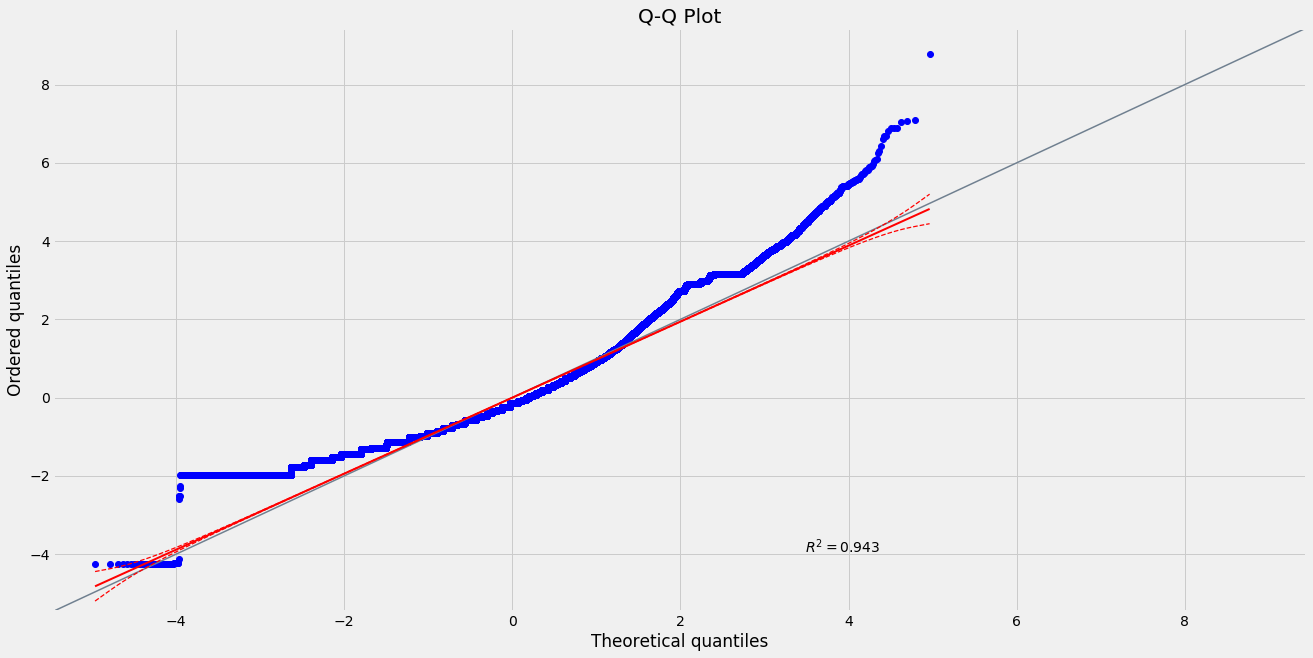

In [9]:
# Cria o gráfico
pg.qqplot(np.log1p(df['fare_amount']), 
          dist='norm', 
          figsize=(20, 10))

# Mostra o gráfico
plt.show()

In [10]:
def select_within_boundingbox(df, BB):
    return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
           (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
           (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
           (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])
            

In [11]:
def plot_hires(df, BB, ax=None, c=('r', 'b')):
    if ax == None:
        fig, ax = plt.subplots(1, 1)

    idx = select_within_boundingbox(df, BB)
    ax.scatter(df[idx].pickup_longitude, df[idx].pickup_latitude, c=c[0], s=0.01, alpha=0.5)
    ax.scatter(df[idx].dropoff_longitude, df[idx].dropoff_latitude, c=c[1], s=0.01, alpha=0.5)

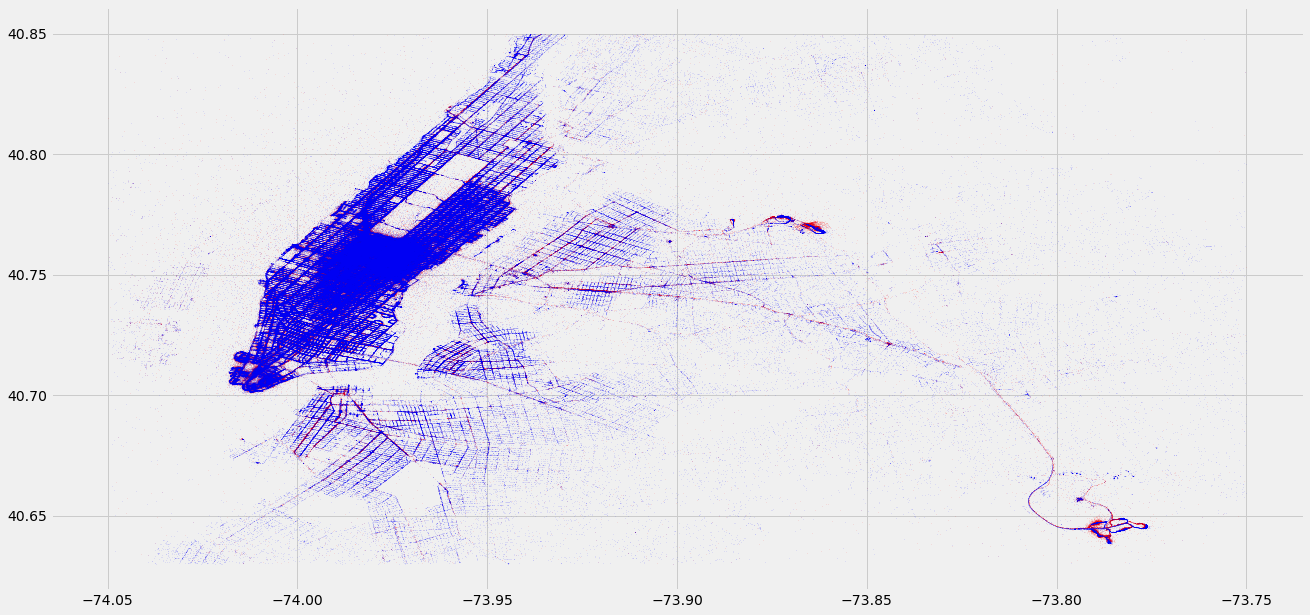

In [12]:
plot_hires(df, (-74.05, -73.75, 40.63, 40.85))

In [13]:
df['year'] = df['pickup_datetime'].dt.year
df['month'] = df['pickup_datetime'].dt.month
df['day'] = df['pickup_datetime'].dt.day
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
df['hour'] = df['pickup_datetime'].dt.hour

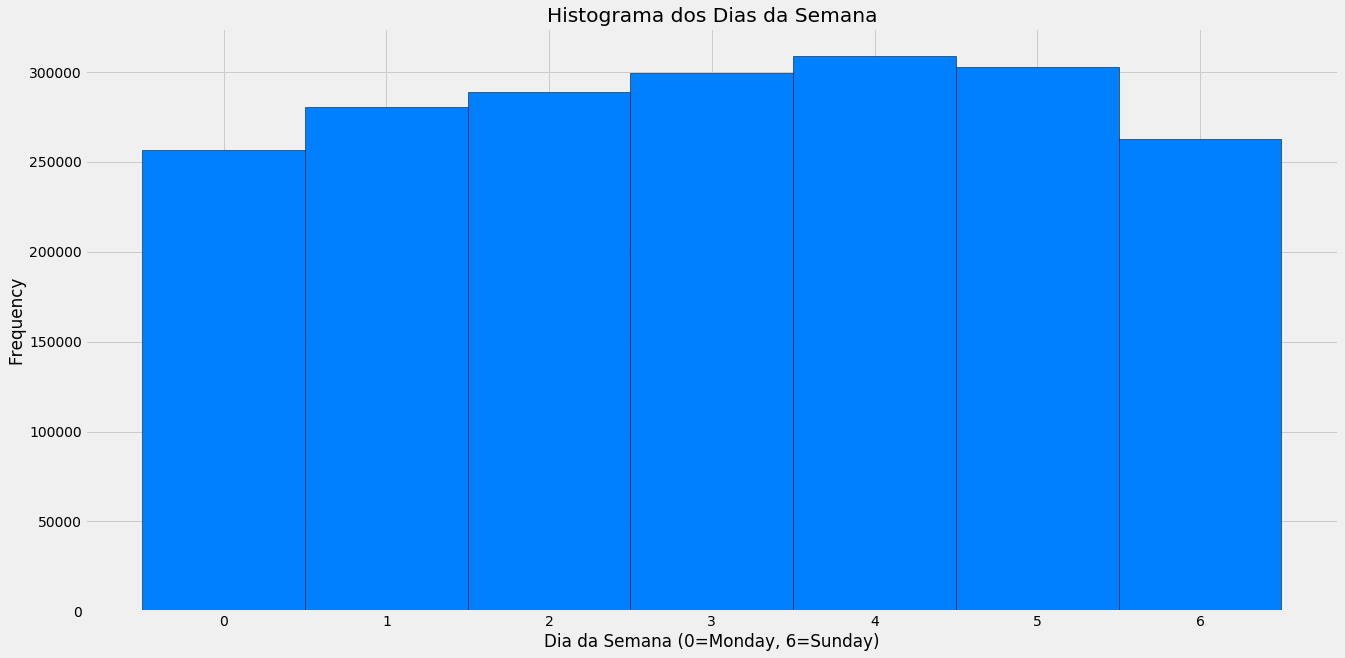

In [14]:
# Histograma e density plot para a variável 'fare_amount'
df['day_of_week'].plot.hist(bins=np.arange(8)-0.5, 
                            ec='black')

# Plota o histograma
plt.xlabel('Dia da Semana (0=Monday, 6=Sunday)')
plt.title('Histograma dos Dias da Semana')
plt.show()

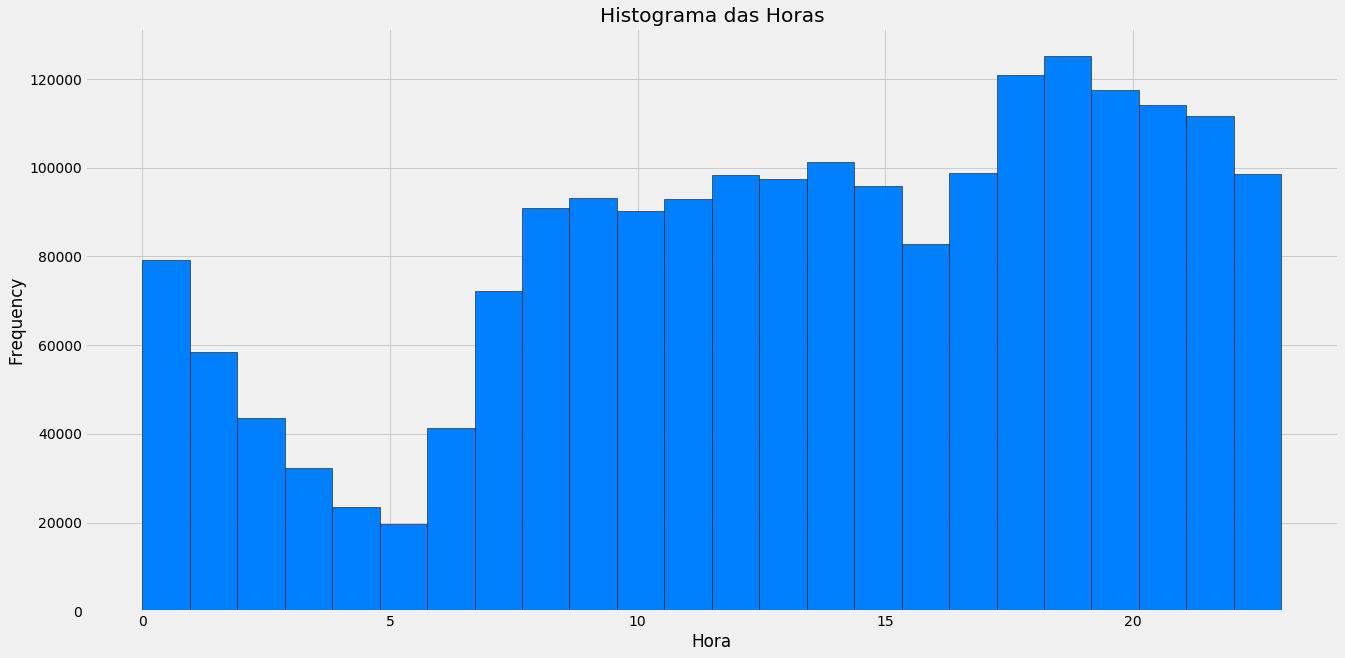

In [15]:
df['hour'].plot.hist(bins=24, ec='black')
plt.title('Histograma das Horas')
plt.xlabel('Hora')
plt.show()